In [1]:
# Imports:
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice
import os
from PIL import Image
from IPython.display import display
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, ReLU, ELU
# from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K
from keras.utils import plot_model
from keras.metrics import BinaryIoU, Precision, Recall, MeanIoU
from keras.losses import BinaryCrossentropy
import tensorflow_datasets as tfds
import tensorflow as tf
import glob
import random
import itertools
# import cv2
from random import shuffle

# KH: Stop tensorflow from grabbing the entire GPU, as we need to share it with someone else
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2024-02-03 13:57:46.773492: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def mIoU_metric(y_true, y_pred):
    yt0 = K.cast(y_true[:,:,:,0] > 0.5, 'float32')
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')

    inter0 = tf.math.count_nonzero(tf.math.logical_and(tf.math.equal(yt0, 0), tf.math.equal(yp0, 0)))
    union0 = tf.math.count_nonzero(tf.math.logical_or(tf.math.equal(yt0, 0), tf.math.equal(yp0, 0)))
    iou0 = tf.where(tf.equal(union0, 0), 1., tf.cast(inter0/union0, 'float32'))

    inter1 = tf.math.count_nonzero(tf.math.logical_and(tf.math.equal(yt0, 1), tf.math.equal(yp0, 1)))
    union1 = tf.math.count_nonzero(tf.math.add(yt0, yp0))
    iou1 = tf.where(tf.equal(union1, 0), 1., tf.cast(inter1/union1, 'float32'))    

    meanIoU = (iou0 + iou1)/2
    return meanIoU

iou_buildIn = tf.keras.metrics.MeanIoU(num_classes=2)

2024-02-03 13:57:51.796408: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-03 13:57:52.178412: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20701 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:81:00.0, compute capability: 8.6


In [3]:
# Define Sobel edge loss function (Seale et al., 2022)
def sobel_edge_loss(y_true, y_pred):

  yt0 = tf.cast(y_true, tf.float32)
  yp0 = tf.cast(y_pred, tf.float32)

  # Calculate the Sobel edges for the ground truth and predicted images
  sobel_true = tf.image.sobel_edges(yt0)
  sobel_pred = tf.image.sobel_edges(yp0)

  # Calculate the mean squared error between the Sobel edges of the ground truth and predicted images
  loss = tf.reduce_mean(tf.square(sobel_true - sobel_pred))
  return loss

def sobel_crossentropy(y_true, y_pred):
  return sobel_edge_loss(y_true, y_pred) + BinaryCrossentropy()(y_true, y_pred)

In [10]:
# NN - model
def unet_CoastDetection(input_shape = (512, 512, 3)):       
  x = Input(input_shape)
  inputs = x

  #down sampling
  f = 8
  layers = []

  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64

  #bottleneck
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1

  #upsampling
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1


  #classification
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)

  #model creation
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', Precision(), Recall(), BinaryIoU(), mIoU_metric])

  return model

In [12]:
# # New model - taken from paper
# # Sobel edge loss

# def double_conv_block(x, num_filters):
#     # Conv2D then ELU activation
#     x = Conv2D(num_filters, 3, activation='relu', padding="same")(x)
#     # x = BatchNormalization()(x)
#     # x = ReLU()(x)
#     # Conv2D then ELU activation
#     x = Conv2D(num_filters, 3, activation='relu', padding="same")(x)
#     # x = BatchNormalization()(x)
#     # x = ReLU()(x)
#     return x

# def unet_CoastDetection(input_shape = (512, 512, 3)):       
#   x = Input(input_shape)
#   inputs = x

#   #down sampling
#   num_filters = 16
#   layers = []

#   # encoder path:
#   for _ in range(0, 4):
#     x = double_conv_block(x, num_filters)
#     layers.append(x)
#     x = MaxPooling2D(2)(x)
#     num_filters = num_filters*2
  
#   ff2 = num_filters // 2

#   # bottleneck:
#   j = len(layers) - 1
#   x = double_conv_block(x, num_filters)
#   x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
#   x = Concatenate(axis=3)([x, layers[j]])
#   j = j - 1

#   #upsampling
#   for _ in range(0, 3):
#     ff2 = ff2 // 2
#     num_filters = num_filters // 2
#     x = double_conv_block(x, num_filters)
#     x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same')(x)
#     x = Concatenate(axis=3)([x, layers[j]])
#     j = j - 1

#   # classification
#   num_filters = num_filters // 2
#   x = double_conv_block(x, num_filters)
#   outputs = Conv2D(1, 1, activation='sigmoid')(x)

#   #model creation
#   model = Model(inputs=[inputs], outputs=[outputs])
#   model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', Precision(), Recall(), BinaryIoU(), mIoU_metric])

#   return model

In [15]:
# Load trained model:

# model = unet_CoastDetection()
# model.load_weights('./trained_models/unet_glacierDetection2-24.h5')

model = keras.models.load_model('/root/workspace_private/trained_models/glacier_model12.keras', custom_objects={"sobel_crossentropy":sobel_crossentropy, "mIoU_metric": mIoU_metric}) # 

In [5]:
# Data:

def sample_loader(dataset, split):
  data = tfds.load(dataset, split=split)
  data = data.map(lambda x: (x['image'], x['mask']))
  return tfds.as_numpy(data)

def batch_loader(dataset, split, batch_size):
  do_shuffle = (split == 'train')
  data = tfds.load(dataset, split=split, shuffle_files=do_shuffle)
  data = data.map(lambda x: (x['image'] / 255, x['mask'] > 0))
  if do_shuffle:
    data = data.shuffle(1024 * 16)
  data = data.batch(batch_size)
  return data

def show_sample(sample):
  image, mask = sample
  mask = np.concatenate([mask]*3, axis=-1)
  viz = np.concatenate([image, mask], axis=1)
  display(Image.fromarray(viz))


coasts_test = sample_loader('glaciers', 'test')
coasts_test_batches = batch_loader('glaciers', 'test', 32)
coasts_iter = iter(coasts_test)

n_test = len(coasts_test)

In [6]:
# indices_list = [708, 5083, 18145, 2411]
indices_list = [5, 13, 25, 36, 70, 77, 81]

Test sample:


2024-02-03 14:02:47.758806: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


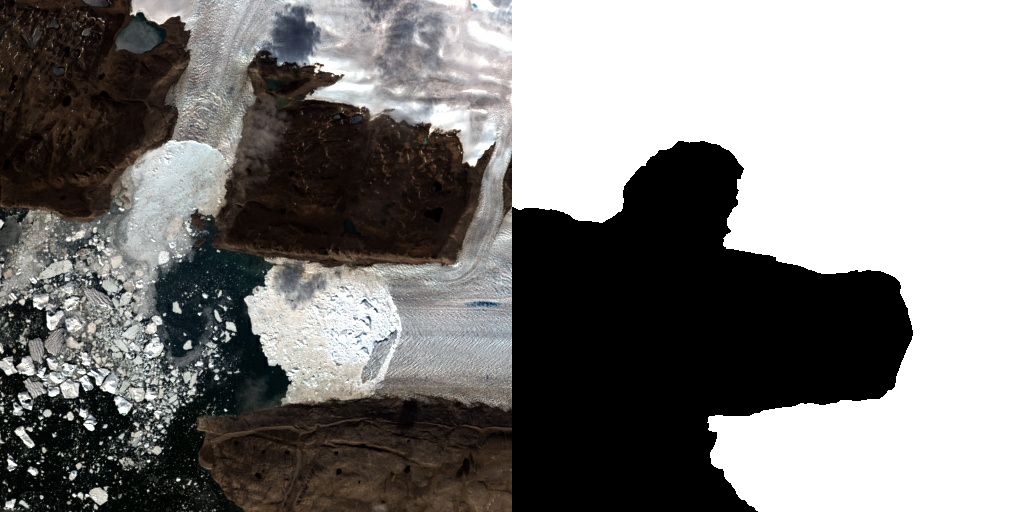


Prediction:


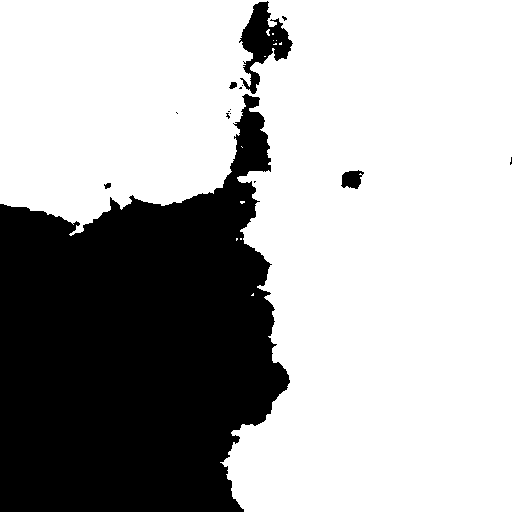

Intersection of Union:  tf.Tensor(0.77474976, shape=(), dtype=float32)


In [16]:
# Test prediction on single image

# sample = next(coasts_iter)
# image, mask = sample
for i in range(1):
    # img_index = random.randint(1, n_test)
    img_index = i+3
    sample = list(islice(coasts_test, img_index-1, img_index))
    image, mask = sample[0]
    print('Test sample:')
    show_sample(sample[0])

    # print('Test sample:')
    # show_sample(sample)

    image = np.asarray(image)[None, ...]
    msk_true = np.asarray(mask)[None, ...]
    pred = model(image, training=False)

    # mask post-processing
    msk_pred  = pred[0,:,:,0]
    msk_pred = np.stack((msk_pred,)*3, axis=-1)
    msk_pred[msk_pred >= 0.5] = 255
    msk_pred[msk_pred < 0.5] = 0

    # show the mask and the segmented image
    # combined = np.concatenate([image[0,:,:,:], msk_pred, image[0,:,:,:]*msk_pred], axis = 1)
    print('\nPrediction:')
    # fig = plt.figure()

    # plt.axis('off')
    # plt.imshow(msk_pred)
    # plt.show()

    img = Image.fromarray(image[0,...])
    msk = Image.fromarray(np.concatenate([mask]*3, axis=-1))
    img_pred = Image.fromarray(msk_pred.astype(np.uint8))

    img_pred.save(f'/root/workspace_private/example_images/gl_{img_index}_pred_GlT_sbce.png')
    # img.save(f'/root/workspace_private/example_images/gl_{img_index}_image.png')
    # msk.save(f'/root/workspace_private/example_images/gl_{img_index}_mask.png')

    display(img_pred)


    iou = mIoU_metric(msk_true, pred)
    print('Intersection of Union: ', iou)

# i += 1


In [22]:
# pred_list = model.predict(coasts_test_batches) Can't allocate enough memory
metric_eval = model.evaluate(coasts_test_batches)

3/3 [==============================] - 1s 70ms/step - loss: 0.6206 - accuracy: 0.7219 - precision: 0.7796 - recall: 0.7626 - binary_io_u: 0.5522 - mIoU_metric: 0.5538


In [ ]:
print(f'Mean loss for test data: {metric_eval[0]:f} \nBinary IoU: {metric_eval[4]:f}\nF1-score:{2*metric_eval[2]*metric_eval[3]/(metric_eval[2]+metric_eval[3]):f}')
# unet_CoastDetection-030: 0.292, 0.779
# unet_CoastDetection2-45: 0.224, 0.864
# unet_CoastDetection2-30: 0.211, 0.865
# unet_CoastDetection2-25: 0.191, 0.866
# unet_CoastDetection2-20: 0.170, 0.867 <------
# unet_CoastDetection2-15: 0.161, 0.870
# unet_CoastDetection2-10: 0.187, 0.846
# unet_CoastDetection3-30: 0.210, 0.263
# unet_Coastdetection5-30: 0.021, 0.8024
# unet_CoastDetection6-21: 0.0220, 0.91 BAD
# unet_CoastDetection10-20: 0.243, 0.808
# unet_CoastDetection11-25: 0.1875, 0.848 loss: 0.1875 - accuracy: 0.9181 - precision: 0.9281 - recall: 0.8967 - binary_io_u: 0.8480 - mIoU_metric: 0.8475


Mean loss for test data: 0.230592 
Binary IoU: 0.829151
F1-score:0.900332


In [14]:
# test spatial accuracy:

def get_contours(img, y_true, y_pred, show_plot=False):
    
   cs_true = plt.contour(y_true[:,:,0], colors='red')
   cs_pred = plt.contour(y_pred[:,:,0])

   cont_len_true = len(cs_true.collections[0].get_paths()[0])
   vertices_true = cs_true.allsegs[0][:][0]

   pred_segs = cs_pred.allsegs
   pred_x = []
   pred_y = []

   # Extract the coordinates of every single contour point (of prediction):
   for k in range(len(pred_segs)):
      pred_elems = pred_segs[k]
      for j in range(len(pred_elems)):                         
         pred_vertices = pred_segs[k][j]
         xij= pred_vertices[:,0]                        
         yij = pred_vertices[:,1]
         pred_x = np.concatenate((pred_x, xij))
         pred_y = np.concatenate((pred_y, yij))

   if show_plot:
      plt.imshow(img)
      plt.axis('off')
      plt.show()
   else:
      plt.close()

   return vertices_true, pred_x, pred_y


def closest_coordinate(point, contour_coordinates, d_max=512):

    min_distance = d_max
    for coord in contour_coordinates:
        distance = np.linalg.norm(np.array(point) - np.array(coord))
        if distance < min_distance:
            min_distance = distance
    
    return min_distance


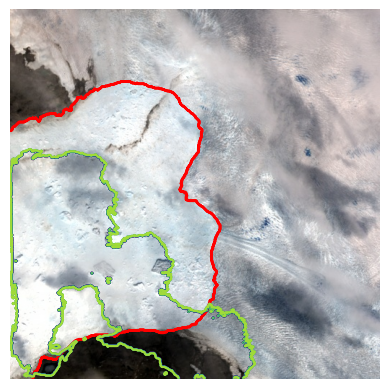

In [20]:
msk_vertices, pred_x, pred_y = get_contours(image[0,:,:,:], msk_true[0,:,:,:], msk_pred, show_plot=True)


# contour_coordinates = [(x,y) for (x,y) in zip(msk_vertices[:,0],msk_vertices[:,1])]
# distances_to_coastline = [closest_coordinate(point, contour_coordinates) for point in zip(pred_x, pred_y)] ### !!!! (very) long computation time, is there a more efficient way?

# print(distances_to_coastline)

[18.638118638118637, 41.97964197964198, 57.27740727740728, 74.70457470457471, 90.92079092079092, 99.47349947349947, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


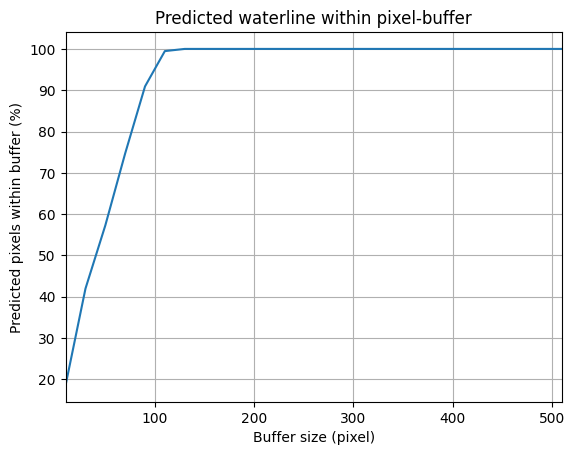

In [ ]:
tot_points = len(distances_to_coastline)

buffer_list = np.arange(10, 512, 20)
part_per_buffer = []
for buffer in buffer_list:
    points_within_buffer = len([dist for dist in distances_to_coastline if dist <= buffer])
    part_per_buffer.append(points_within_buffer*100/tot_points)

print(part_per_buffer)

fig, ax = plt.subplots(1,1)
ax.plot(buffer_list, part_per_buffer)
ax.grid()
plt.xlabel('Buffer size (pixel)')
plt.ylabel('Predicted pixels within buffer (%)')
ax.set_xlim(buffer_list[0], buffer_list[-1])
# ax.set_xticks(buffer_list)
plt.title("Predicted waterline within pixel-buffer")
plt.show()

In [18]:
# Here: compute the overall spatial accuracy (average) over all samples

buffer_list = np.arange(0, 512, 5)
buffer_sum = np.zeros_like(buffer_list, dtype=float)


for i, sample in enumerate(coasts_test):
    img, y_true = sample

    img = np.asarray(img)[None, ...]
    # msk_true = np.asarray(mask)[None, ...]
    pred = model(img, training=False)

    # mask post-processing
    y_pred  = pred[0,:,:,0]
    y_pred = np.stack((y_pred,)*3, axis=-1)
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0

    msk_vertices, pred_x, pred_y = get_contours(img[0,:,:,:], y_true, y_pred, show_plot=False)

    contour_coordinates = [(x,y) for (x,y) in zip(msk_vertices[:,0],msk_vertices[:,1])]
    distances_to_coastline = [closest_coordinate(point, contour_coordinates) for point in zip(pred_x, pred_y)] ### !!!! (very) long computation time, is there a more efficient way?

    
    tot_points = len(distances_to_coastline)

    part_per_buffer = []
    for buffer in buffer_list:
        points_within_buffer = len([dist for dist in distances_to_coastline if dist <= buffer])
        part_per_buffer.append(points_within_buffer*100/tot_points)

    buffer_sum += np.array(part_per_buffer)

    print(part_per_buffer)

    # fig, ax = plt.subplots(1,1)
    # ax.plot(buffer_list, part_per_buffer)
    # ax.grid()
    # plt.xlabel('Buffer size (pixel)')
    # plt.ylabel('Predicted pixels within buffer (%)')
    # ax.set_xlim(buffer_list[0], buffer_list[-1])
    # # ax.set_xticks(buffer_list)
    # plt.title("Predicted waterline within pixel-buffer")
    # plt.show()

    # if i%1000==0: print(f'{i}/{n_test}')

    if i%5 == 0: print(f'Processed images: {i}/{len(coasts_test)}')
    # if i == 10: break

buffer_mean = buffer_sum/n_test

fig, ax = plt.subplots(1,1)
ax.plot(buffer_list, buffer_mean)
ax.grid()
plt.xlabel('Buffer size (pixel)')
plt.ylabel('Predicted pixels within buffer (%)')
ax.set_xlim(buffer_list[0], buffer_list[-1])
# ax.set_xticks(buffer_list)
plt.title("Average predicted waterline within pixel-buffer")
plt.show()


[0.028047722680739004, 2.3175729370640266, 4.688644308130204, 7.2752676220205785, 9.791771629209107, 12.115057991263654, 14.00568226085421, 16.295207475237497, 18.39203444675867, 20.726228256522393, 23.640075001688057, 25.921289779721498, 27.994224246736856, 30.55903266520888, 33.004897963423694, 35.66891221582203, 38.029595541450895, 40.842678245874644, 44.1003692950153, 47.70605986630586, 50.89830622919145, 53.73320382903355, 57.03192765765157, 59.86578645294995, 62.83780625256455, 66.18847030836913, 69.63782079582816, 73.32194111017041, 76.73233642723953, 79.76252928130307, 82.88205932612749, 86.02859828908892, 88.26722208082938, 90.85540360153536, 93.22907198396086, 94.9690695947104, 96.35171844241647, 96.88981919606917, 97.38688717024448, 97.68294646520783, 97.90784764892561, 98.13326823491526, 98.42361410488809, 98.62981680681871, 98.81524341787471, 98.88744033366402, 98.97054469716251, 99.15441310140291, 99.44891418955066, 99.68576162552135, 99.8659942138587, 99.98961195456269, 

2024-02-03 09:26:40.341063: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


KeyboardInterrupt: 

In [24]:
np.save('/root/workspace_private/coastDetection_trL_BCE_buffers.npy', buffer_mean)
print(buffer_mean)

[7.94759680e-02 7.72042427e+00 1.35644965e+01 1.86824699e+01
 2.37199456e+01 2.84170021e+01 3.30786469e+01 3.75142058e+01
 4.17004862e+01 4.57655950e+01 4.93938846e+01 5.29098214e+01
 5.61582094e+01 5.90780574e+01 6.15912400e+01 6.37293680e+01
 6.57077148e+01 6.76394162e+01 6.96621380e+01 7.14895203e+01
 7.29798055e+01 7.42112537e+01 7.53669081e+01 7.63570352e+01
 7.73884304e+01 7.83339731e+01 7.91807136e+01 8.00111162e+01
 8.07980672e+01 8.15629820e+01 8.23229989e+01 8.30539142e+01
 8.36895620e+01 8.42168906e+01 8.46859506e+01 8.51789190e+01
 8.56489592e+01 8.60990752e+01 8.64520265e+01 8.67508516e+01
 8.70440919e+01 8.73019917e+01 8.75591970e+01 8.78382861e+01
 8.80357889e+01 8.82130934e+01 8.84278072e+01 8.86083937e+01
 8.87747254e+01 8.90028424e+01 8.92222961e+01 8.94316497e+01
 8.95943169e+01 8.97810516e+01 8.99369339e+01 9.00625085e+01
 9.02110874e+01 9.03776446e+01 9.04955034e+01 9.06104092e+01
 9.07386849e+01 9.08916016e+01 9.10186914e+01 9.11415445e+01
 9.12863387e+01 9.143597

[19.05228358026203, 36.978082527243785, 37.06379331455859, 37.06379331455859, 37.06379331455859, 37.06379331455859, 37.06379331455859, 37.06379331455859, 37.06379331455859, 37.06379331455859, 37.06379331455859, 37.06379331455859, 37.06379331455859, 37.06379331455859, 37.06379331455859, 37.52295824660218, 45.70833843516591, 57.077262152565204, 61.246479735521, 65.01775437737236, 68.46455246724624, 83.23129668176809, 94.6553201910126, 98.68372719480837, 100.0, 100.0]


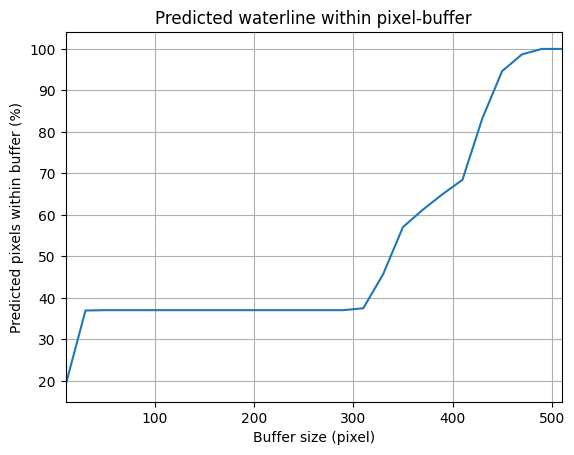